# Table of Contents
 <p><div class="lev1"><a href="#Load-the-data,-split-in-train-and-test-sets,-create-synthetic-data,-create-pipeline-and-generator-of-batches"><span class="toc-item-num">1 - </span>Load the data, split in train and test sets, create synthetic data, create pipeline and generator of batches</a></div><div class="lev2"><a href="#Define-target-appliance,-split-in-train-and-test-sets"><span class="toc-item-num">1.1 - </span>Define target appliance, split in train and test sets</a></div><div class="lev2"><a href="#Get-the-activation-sequences-of-the-target-appliance-in-train-and-test-sets"><span class="toc-item-num">1.2 - </span>Get the activation sequences of the target appliance in train and test sets</a></div><div class="lev2"><a href="#Create-the-synthetic-data-and-collect-the-aggregated-real-data"><span class="toc-item-num">1.3 - </span>Create the synthetic data and collect the aggregated real data</a></div><div class="lev2"><a href="#Create-the-generator-of-batches-to-use-during-training"><span class="toc-item-num">1.4 - </span>Create the generator of batches to use during training</a></div><div class="lev2"><a href="#Play-with-the-generator"><span class="toc-item-num">1.5 - </span>Play with the generator</a></div><div class="lev2"><a href="#How-to-get-a-batch-from-real/synthetic-data.-Show-that-data-is-balanced-(nb-activated-=-nb-not-activated)"><span class="toc-item-num">1.6 - </span>How to get a batch from real/synthetic data. Show that data is balanced (nb activated = nb not activated)</a></div><div class="lev2"><a href="#Test-the-rectangle-function-to-prepare-Y_train"><span class="toc-item-num">1.7 - </span>Test the rectangle function to prepare Y_train</a></div><div class="lev1"><a href="#Training-using-Keras"><span class="toc-item-num">2 - </span>Training using Keras</a></div><div class="lev2"><a href="#Using-fit_generator"><span class="toc-item-num">2.1 - </span>Using fit_generator</a></div><div class="lev2"><a href="#with-fit-method-(get-rid-off-the-generator-for-testing-purposes)"><span class="toc-item-num">2.2 - </span>with fit method (get rid off the generator for testing purposes)</a></div>

# Load the data, split in train and test sets, create synthetic data, create pipeline and generator of batches

## Define target appliance, split in train and test sets

In [1]:
from __future__ import print_function
%matplotlib inline
from matplotlib.pylab import plt
from matplotlib import rcParams
rcParams['figure.figsize'] = (13, 6)
plt.style.use('ggplot')
import nilmtk
from nilmtk.utils import print_dict
from nilmtk import DataSet
from neuralnilm.data.loadactivations import load_nilmtk_activations
from neuralnilm.data.syntheticaggregatesource import SyntheticAggregateSource
from neuralnilm.data.realaggregatesource import RealAggregateSource
from neuralnilm.data.stridesource import StrideSource
from neuralnilm.data.datapipeline import DataPipeline
from neuralnilm.data.processing import DivideBy, IndependentlyCenter
import numpy as np

# create dictionary with train, unseen_house, unseen_appliance
def select_windows(train_buildings, unseen_buildings):
    windows = {fold: {} for fold in DATA_FOLD_NAMES}

    def copy_window(fold, i):
        windows[fold][i] = WINDOWS[fold][i]

    for i in train_buildings:
        copy_window('train', i)
        copy_window('unseen_activations_of_seen_appliances', i)
    for i in unseen_buildings:
        copy_window('unseen_appliances', i)
    return windows


def filter_activations(windows, activations):
    new_activations = {
        fold: {appliance: {} for appliance in APPLIANCES}
        for fold in DATA_FOLD_NAMES}
    for fold, appliances in activations.iteritems():
        for appliance, buildings in appliances.iteritems():
            required_building_ids = windows[fold].keys()
            required_building_names = [
                'UK-DALE_building_{}'.format(i) for i in required_building_ids]
            for building_name in required_building_names:
                try:
                    new_activations[fold][appliance][building_name] = (
                        activations[fold][appliance][building_name])
                except KeyError:
                    pass
    return activations    



NILMTK_FILENAME = './redd_data/redd.h5'
SAMPLE_PERIOD = 6
STRIDE = None
APPLIANCES = ['fridge']
WINDOWS = {
    'train': {
        1: ("2011-04-19", "2011-05-21"),
        2: ("2011-04-19", "2013-05-01"),
        3: ("2011-04-19", "2013-05-26"),
        6: ("2011-05-22", "2011-06-14"),
    },
    'unseen_activations_of_seen_appliances': {
        1: ("2011-04-19", None),
        2: ("2011-04-19", None),
        3: ("2011-04-19", None),
        6: ("2011-05-22", None),
    },
    'unseen_appliances': {
        5: ("2011-04-19", None)
    }
}

## Get the activation sequences of the target appliance in train and test sets

In [2]:
## get the dictionary of activations for each appliance
activations = load_nilmtk_activations(
    appliances=APPLIANCES,
    filename=NILMTK_FILENAME,
    sample_period=SAMPLE_PERIOD,
    windows=WINDOWS
)

# get pipeline for the fridge example
num_seq_per_batch = 64
target_appliance = 'fridge'
seq_length = 512
train_buildings = [1]
unseen_buildings = [5]
DATA_FOLD_NAMES = (
    'train', 'unseen_appliances', 'unseen_activations_of_seen_appliances')
filtered_windows = select_windows(train_buildings, unseen_buildings)
filtered_activations = filter_activations(filtered_windows, activations)

/Users/thibaut/Dropbox/Courses/am207/project/nilmtk/nilmtk/utils.py:383: FutureWarning: fill_method is deprecated to .resample()
the new syntax is .resample(...).ffill(limit=9)
  data = data.resample(**resample_kwargs)


## Create the synthetic data and collect the aggregated real data

In [3]:
synthetic_agg_source = SyntheticAggregateSource(
    activations=filtered_activations,
    target_appliance=target_appliance,
    seq_length=seq_length,
    sample_period=SAMPLE_PERIOD
)

real_agg_source = RealAggregateSource(
    activations=filtered_activations,
    target_appliance=target_appliance,
    seq_length=seq_length,
    filename=NILMTK_FILENAME,
    windows=filtered_windows,
    sample_period=SAMPLE_PERIOD
)

/Users/thibaut/Dropbox/Courses/am207/project/nilmtk/nilmtk/metergroup.py:901: UserWarning: As a quick implementation we only get Good Sections from the first meter in the meter group.  We should really return the intersection of the good sections for all meters.  This will be fixed...
  warn("As a quick implementation we only get Good Sections from"
/Users/thibaut/anaconda/envs/nilmtk-env/lib/python2.7/site-packages/pandas/tseries/base.py:155: VisibleDeprecationWarning: using a non-integer number instead of an integer will result in an error in the future
  val = getitem(key)


Loading data for meter ElecMeterID(instance=2, building=1, dataset='REDD')     

/Users/thibaut/Dropbox/Courses/am207/project/nilmtk/nilmtk/utils.py:332: FutureWarning: .resample() is now a deferred operation
use .resample(...).mean() instead of .resample(...)
  return resampled.index[0]
/Users/thibaut/Dropbox/Courses/am207/project/nilmtk/nilmtk/utils.py:383: FutureWarning: fill_method is deprecated to .resample()
the new syntax is .resample(...).ffill(limit=5)
  data = data.resample(**resample_kwargs)



Done loading data all meters for this chunk.
Loading data for meter ElecMeterID(instance=2, building=1, dataset='REDD')     
Done loading data all meters for this chunk.
Loading data for meter ElecMeterID(instance=2, building=1, dataset='REDD')     
Done loading data all meters for this chunk.
Loading data for meter ElecMeterID(instance=2, building=1, dataset='REDD')     
Done loading data all meters for this chunk.
Loading data for meter ElecMeterID(instance=2, building=1, dataset='REDD')     
Done loading data all meters for this chunk.
Loading data for meter ElecMeterID(instance=2, building=1, dataset='REDD')     
Done loading data all meters for this chunk.
Loading data for meter ElecMeterID(instance=2, building=1, dataset='REDD')     
Done loading data all meters for this chunk.
Loading data for meter ElecMeterID(instance=2, building=1, dataset='REDD')     
Done loading data all meters for this chunk.
Loading data for meter ElecMeterID(instance=2, building=1, dataset='REDD')     

## Create the generator of batches to use during training

In [183]:
from __future__ import print_function, division
from copy import copy
import numpy as np

from neuralnilm.utils import none_to_list


class DataPipeline(object):
    def __init__(self, sources, num_seq_per_batch,
                 input_processing=None,
                 target_processing=None,
                 source_probabilities=None,
                 rng_seed=None):
        self.sources = sources
        self.num_seq_per_batch = num_seq_per_batch
        self.input_processing = none_to_list(input_processing)
        self.target_processing = none_to_list(target_processing)
        num_sources = len(self.sources)
        if source_probabilities is None:
            self.source_probabilities = [1 / num_sources] * num_sources
        else:
            self.source_probabilities = source_probabilities
        self.rng_seed = rng_seed
        self.rng = np.random.RandomState(self.rng_seed)
        self._source_iterators = [None] * num_sources

    def get_batch(self, fold='train', enable_all_appliances=False,
                  source_id=None, reset_iterator=False,
                  validation=False):
        """
        Returns
        -------
        A Batch object or None if source iterator has hit a StopIteration.
        """
        if source_id is None:
            n = len(self.sources)
            source_id = self.rng.choice(n, p=self.source_probabilities)
        if reset_iterator or self._source_iterators[source_id] is None:
            self._source_iterators[source_id] = (
                self.sources[source_id].get_batch(
                    num_seq_per_batch=self.num_seq_per_batch,
                    fold=fold,
                    enable_all_appliances=enable_all_appliances,
                    validation=validation))
        try:
            batch = self._source_iterators[source_id].next()
        except StopIteration:
            self._source_iterators[source_id] = None
            return None
        else:
            batch.after_processing.input, i_metadata = self.apply_processing(
                batch.before_processing.input, 'input')
            batch.after_processing.target, t_metadata = self.apply_processing(
                batch.before_processing.target, 'target')
            batch.metadata.update({
                'source_id': source_id,
                'processing': {
                    'input': i_metadata,
                    'target': t_metadata
                }
            })
            return batch

    def apply_processing(self, data, net_input_or_target):
        """Applies `<input, target>_processing` to `data`.

        Parameters
        ----------
        data : np.ndarray
            shape = (num_seq_per_batch, seq_length, num_features)
        net_input_or_target : {'target', 'input}

        Returns
        -------
        processed_data, metadata
        processed_data : np.ndarray
            shape = (num_seq_per_batch, seq_length, num_features)
        metadata : dict
        """
        processing_steps = self._get_processing_steps(net_input_or_target)
        metadata = {}
        for step in processing_steps:
            data = step(data)
            if hasattr(step, 'metadata'):
                metadata.update(step.metadata)
        return data, metadata

    def apply_inverse_processing(self, data, net_input_or_target):
        """Applies the inverse of `<input, target>_processing` to `data`.

        Parameters
        ----------
        data : np.ndarray
            shape = (num_seq_per_batch, seq_length, num_features)
        net_input_or_target : {'target', 'input}

        Returns
        -------
        processed_data : np.ndarray
            shape = (num_seq_per_batch, seq_length, num_features)
        """
        processing_steps = self._get_processing_steps(net_input_or_target)
        reversed_processing_steps = processing_steps[::-1]
        for step in reversed_processing_steps:
            try:
                data = step.inverse(data)
            except AttributeError:
                pass
        return data

    def _get_processing_steps(self, net_input_or_target):
        assert net_input_or_target in ['input', 'target']
        attribute = net_input_or_target + '_processing'
        processing_steps = getattr(self, attribute)
        assert isinstance(processing_steps, list)
        return processing_steps

    def report(self):
        report = copy(self.__dict__)
        for attr in ['sources', 'rng', '_source_iterators']:
            report.pop(attr)
        report['sources'] = {
            i: source.report() for i, source in enumerate(self.sources)}
        report['input_processing'] = [
            processor.report() for processor in self.input_processing]
        report['target_processing'] = [
            processor.report() for processor in self.target_processing]
        return {'pipeline': report}

    def _get_output_neurons(self, new_batch):
        batch_size = new_batch.target.shape[0]
        neural_net_output = np.empty((batch_size, 3))
        
        for b in range(batch_size):
            seq =  new_batch.target[b]

            # case 1 and 2: if the signal start at 0
            if seq[0] > 0:
                start = 0
                stop_array = np.where(seq > 0)[0]
                # case 2: signal stops after 1
                # set stop to the last element
                if len(stop_array) == 0:
                    stop = seq[-1]
                # case 1: signal stops before 1
                else:
                    stop = stop_array[-1]  
                # calculate avg power
                avg_power =  np.mean(seq[start:stop + 1])

            # case 3: signal starts after 0 and before 1
            else:
                start_array = np.where(seq > 0)[0]
                if len(start_array) == 0:
                    # case 5: there is no signal in the window
                    start = 0
                    stop = 0
                    avg_power = 0
                else:
                    start = start_array[0]
                    # find stop
                    stop_array = np.where(seq > 0)[0]
                    # case 4: signal stops after 1
                    # set to the last element
                    if len(stop_array) == 0:
                        stop = seq[-1]
                    else:
                        stop = stop_array[-1]        
                    avg_power =  np.mean(seq[start:stop + 1])
                    
            start = start / float(new_batch.target.shape[1] - 1)
            stop = stop  / float(new_batch.target.shape[1] - 1)
            if stop < start:
                raise ValueError("start must be before stop in sequence {}".format(b))

            neural_net_output[b, :] = np.array([start, stop, avg_power])

        return neural_net_output        
    
    def train_generator(self, fold='train', enable_all_appliances=False,
                  source_id=None, reset_iterator=False,
                  validation=False ):
        while 1:
            batch_iter = self.get_batch(fold, enable_all_appliances, source_id, reset_iterator,validation)
            X_train = batch_iter.input
            Y_train = self._get_output_neurons(batch_iter)
            yield (X_train, Y_train)
        

In [4]:
sample = real_agg_source.get_batch(num_seq_per_batch=1024).next()
sample = sample.before_processing
input_std = sample.input.flatten().std()
target_std = sample.target.flatten().std()
pipeline = DataPipeline(
    [synthetic_agg_source, real_agg_source],
    num_seq_per_batch=num_seq_per_batch,
    input_processing=[DivideBy(input_std), IndependentlyCenter()],
    target_processing=[DivideBy(target_std)]
)

In [5]:
batch = pipeline.train_generator(fold = 'train', source_id = 0)

[ 0.58708415  0.85322896  2.72287941]


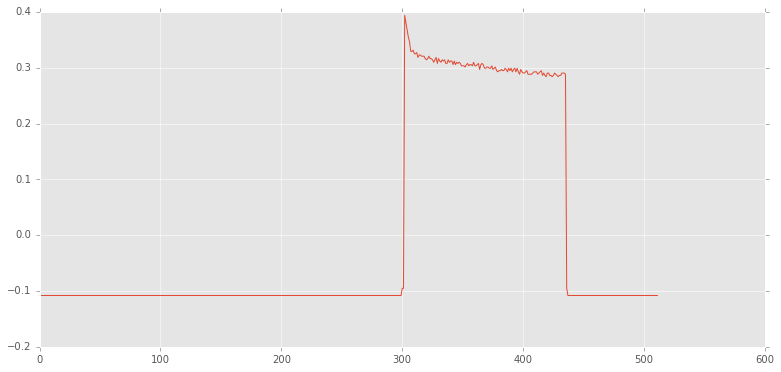

In [8]:
(x,y) = batch.next()
print(y[0])
plt.plot(x[0,0,:])

## Play with the generator

Note that I changed the shape of the generator output in the method *train_generator* compared to the method *get_bacth*. 

In [7]:
batch = pipeline.get_batch()

In [8]:
batch.input.shape

/Users/thibaut/anaconda/envs/nilmtk-env/lib/python2.7/site-packages/IPython/core/formatters.py:92: DeprecationWarning: DisplayFormatter._ipython_display_formatter_default is deprecated: use @default decorator instead.
  def _ipython_display_formatter_default(self):
/Users/thibaut/anaconda/envs/nilmtk-env/lib/python2.7/site-packages/IPython/core/formatters.py:669: DeprecationWarning: PlainTextFormatter._singleton_printers_default is deprecated: use @default decorator instead.
  def _singleton_printers_default(self):


(64, 512, 1)

In [10]:
batch.target.shape

(64, 512, 1)

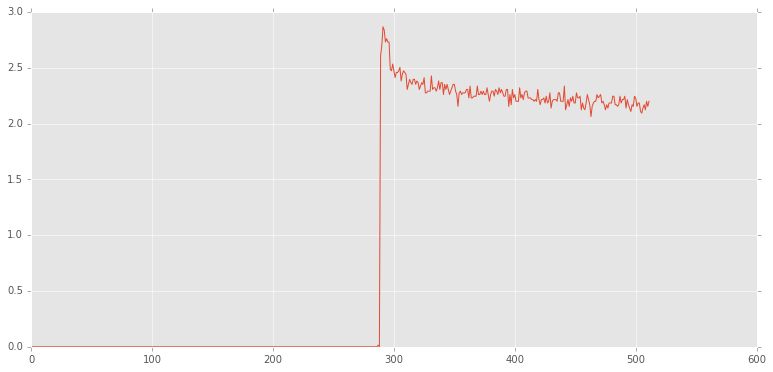

In [11]:
plt.plot(batch.target[59])

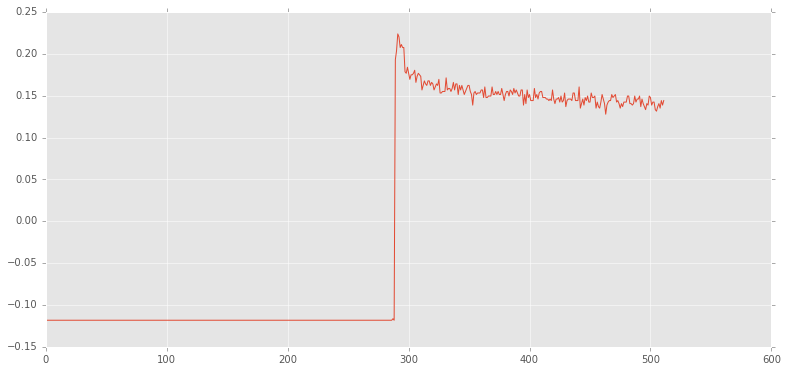

In [12]:
plt.plot(batch.input[59])

In [13]:
new_batch  = pipeline.get_batch()

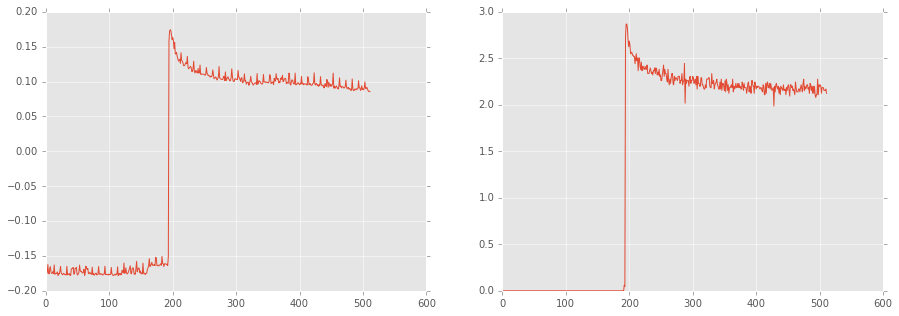

In [15]:
fig, ax =  plt.subplots(1,2, figsize = (15,5))
ax[0].plot(new_batch.input[59])
ax[1].plot(new_batch.target[59])

In [16]:
sample.input.shape

(1024, 512, 1)

In [17]:
# [synthetic_agg_source, real_agg_source]
synthetic_agg_source.num_batches_for_validation

16

In [18]:
real_agg_source.get_num_activations()

{'train': {'fridge': {'REDD_building_1': 313,
   'REDD_building_2': 358,
   'REDD_building_3': 592,
   'REDD_building_6': 249}},
 'unseen_activations_of_seen_appliances': {'fridge': {'REDD_building_1': 350,
   'REDD_building_2': 358,
   'REDD_building_3': 592,
   'REDD_building_6': 249}},
 'unseen_appliances': {'fridge': {'REDD_building_5': 69}}}

## How to get a batch from real/synthetic data. Show that data is balanced (nb activated = nb not activated)

Sample with activations: 29, Sample without activations: 35


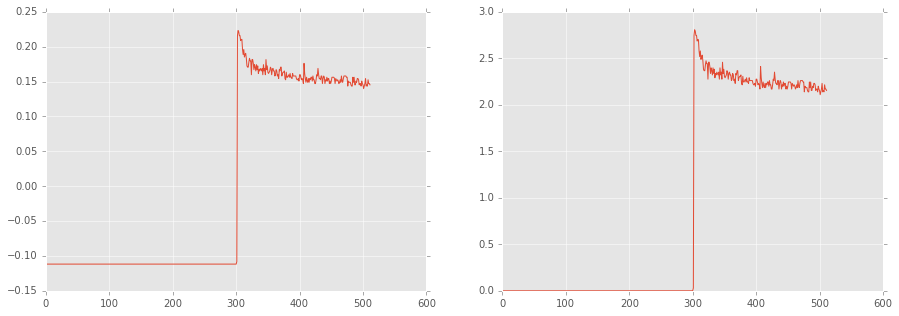

In [19]:
# source_id control the source : 0 is the real aggregated data
#                                1 is the synthetic aggregated data
new_batch = pipeline.get_batch(fold = ' train', source_id = 0)
num_no_activations = np.sum(new_batch.target[:,:,0].sum(axis = 1) == 0)
num_activations = new_batch.target.shape[0] - num_no_activations
print('Sample with activations: {}, Sample without activations: {}'.format(num_activations,num_no_activations))
fig, ax =  plt.subplots(1,2, figsize = (15,5))
ax[0].plot(new_batch.input[59])
ax[1].plot(new_batch.target[59])

## Test the rectangle function to prepare Y_train

Our idea was to train a neural network to estimate three scalar, real-valued outputs: the start time, the end time and mean power demand of the first appliance activation to appear in the aggregate power signal. If there is no target appliance in the aggregate data then all three outputs should be zero. If there is more than one activation in the aggre- gate signal then the network should ignore all but the first activation. All outputs are in the range [0, 1]. The start and end times are encoded as a proportion of the input’s time window. For example, the start of the time window is encoded as 0, the end is encoded as 1 and half way through the time window is encoded as 0.5. For example, consider a scenario where the input window width is 10 minutes and an appliance activation starts 1 minute into the window and ends 1 minute before the end of the window. This activation would be encoded as having a start location of 0.1 and an end location of 0.9.

In [124]:
def get_plot(new_batch, b, fig):
    seq =  new_batch.target[b]

    # case 1 and 2: if the signal start at 0
    if seq[0] > 0:
        start = 0
        stop_array = np.where(seq > 0)[0]
        # case 2: signal stops after 1
        # set stop to the last element
        if len(stop_array) == 0:
            stop = seq[-1]
        # case 1: signal stops before 1
        else:
            stop = stop_array[-1]  
        # calculate avg power
        avg_power =  np.mean(seq[start:stop + 1])

    # case 3: signal starts after 0 and before 1
    else:
        start_array = np.where(seq > 0)[0]
        if len(start_array) == 0:
            # case 5: there is no signal in the window
            start = 0
            stop = 0
            avg_power = 0
        else:
            start = start_array[0]
            # find stop
            stop_array = np.where(seq > 0)[0]
            # case 4: signal stops after 1
            # set to the last element
            if len(stop_array) == 0:
                stop = seq[-1]
            else:
                stop = stop_array[-1]        
            avg_power =  np.mean(seq[start:stop + 1])


    # plot the signal
#     plt.plot([start, stop], [avg_power, avg_power], lw = 4, hold = True)
    plt.figure(fig)
    plt.plot(new_batch.target[b])
#     plt.plot(start, avg_power, 'o')
    plt.ylim([0, new_batch.target[b].max()])
    plt.show()
    print('start {}, stop {}, avg {}'.format(start, stop, avg_power))
    return 

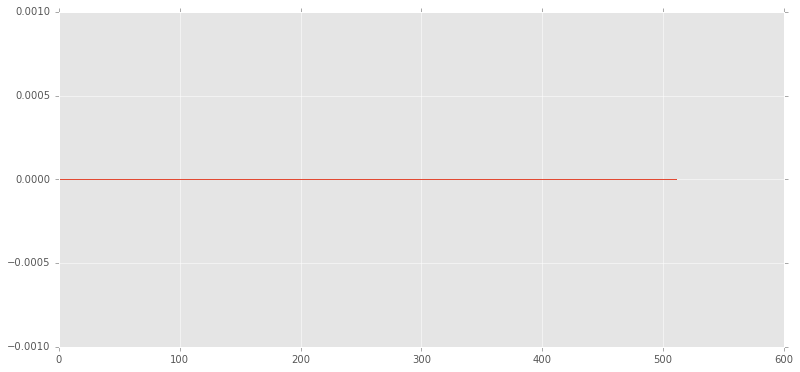

start 0, stop 0, avg 0


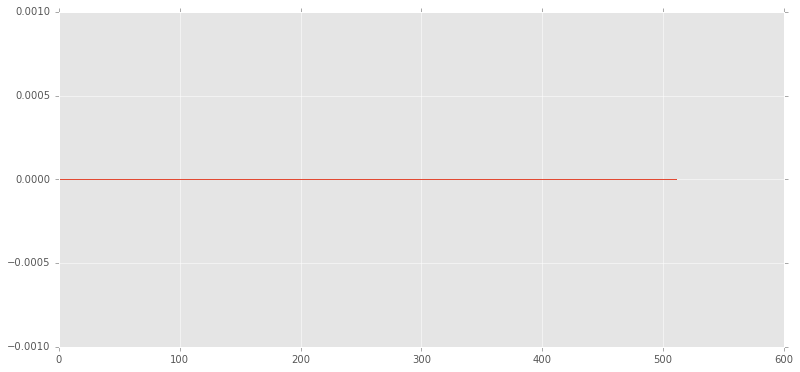

start 0, stop 0, avg 0


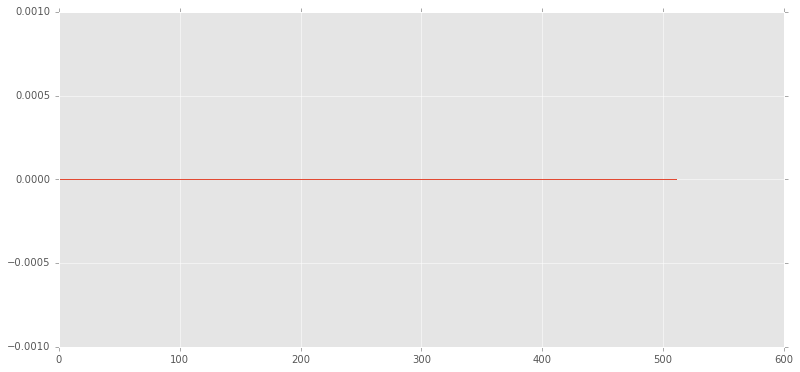

start 0, stop 0, avg 0


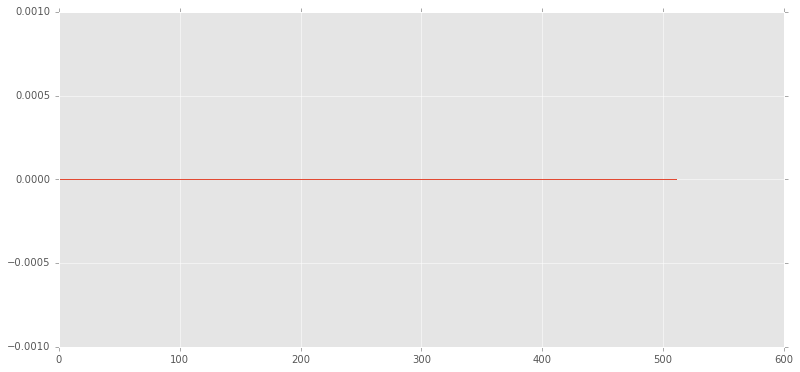

start 0, stop 0, avg 0


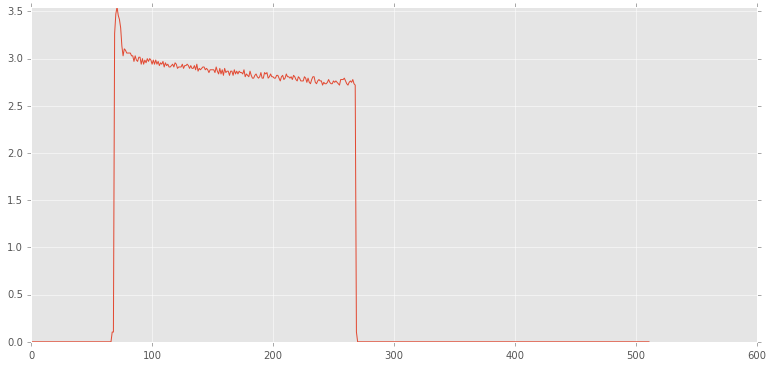

start 67, stop 269, avg 2.8346118927


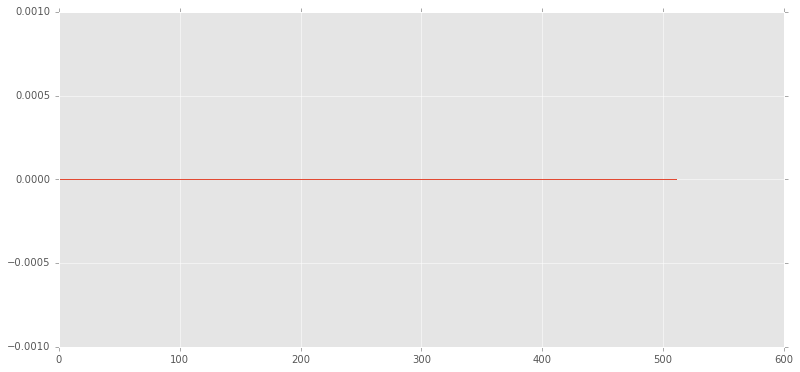

start 0, stop 0, avg 0


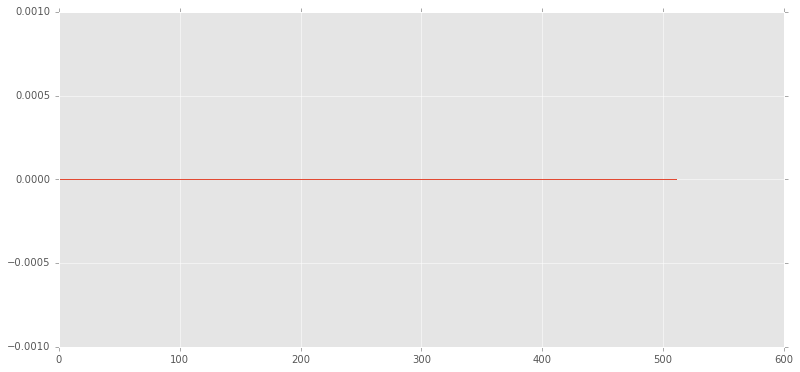

start 0, stop 0, avg 0


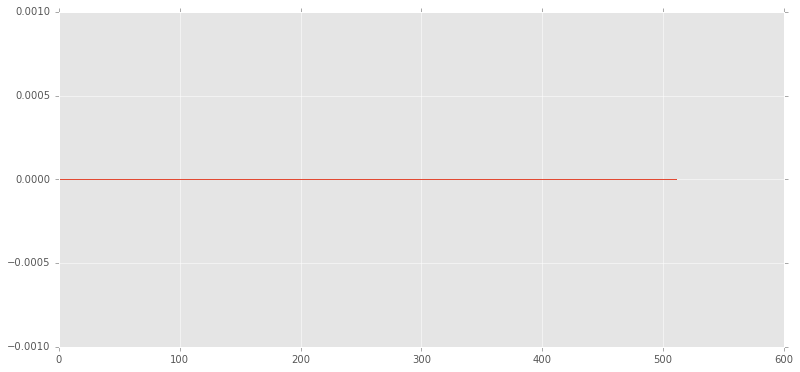

start 0, stop 0, avg 0


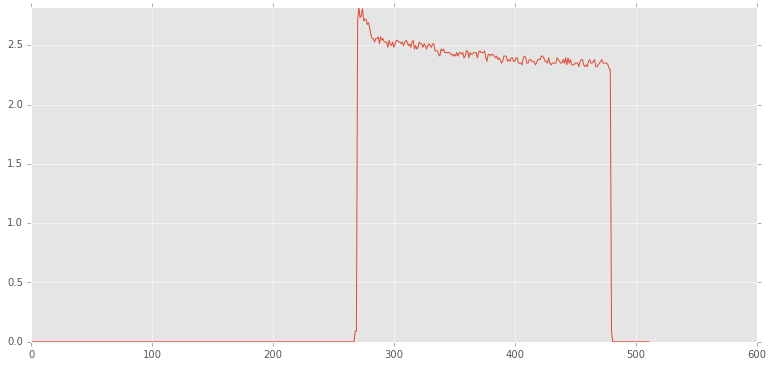

start 268, stop 480, avg 2.40359687805


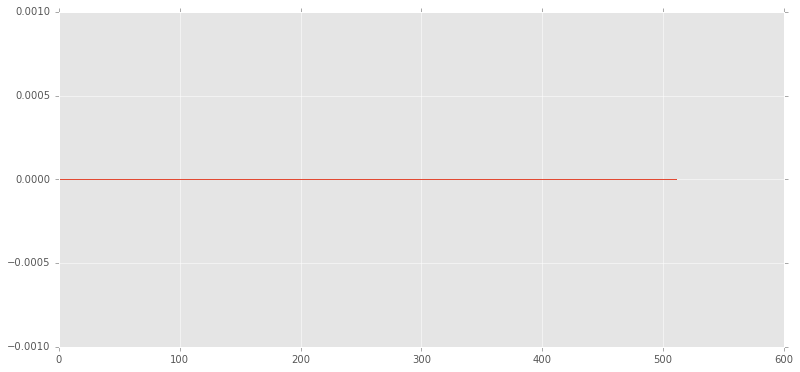

start 0, stop 0, avg 0


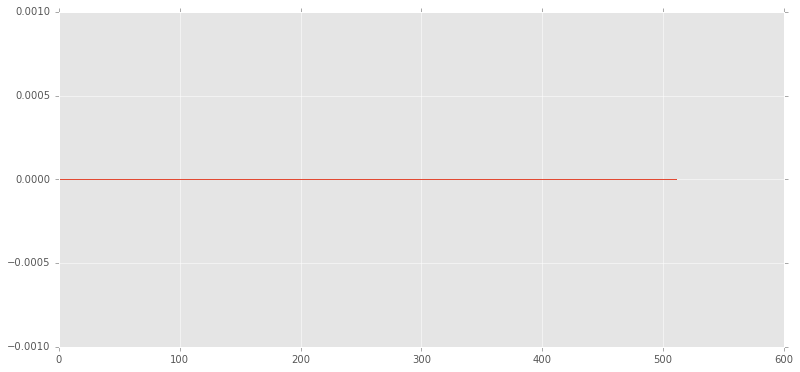

start 0, stop 0, avg 0


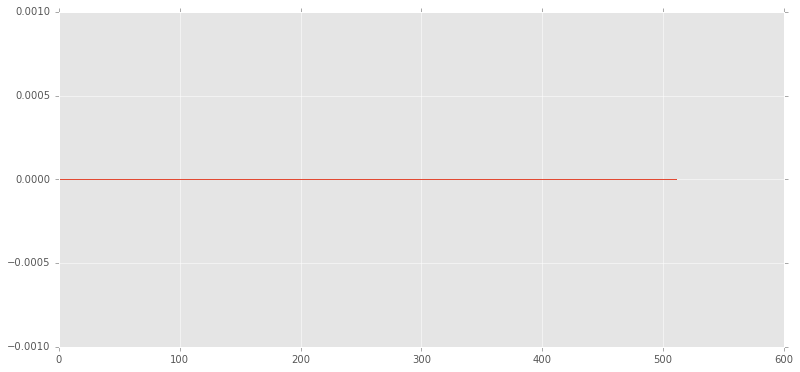

start 0, stop 0, avg 0


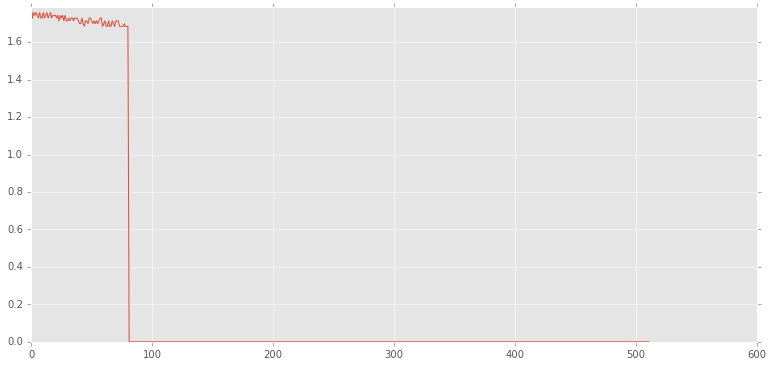

start 0, stop 80, avg 1.71886646748


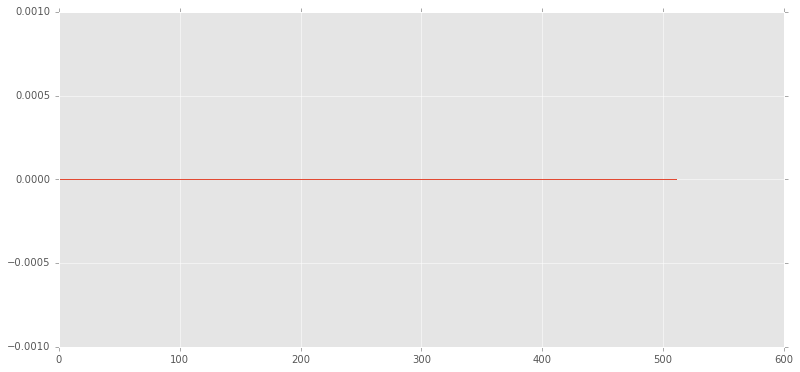

start 0, stop 0, avg 0


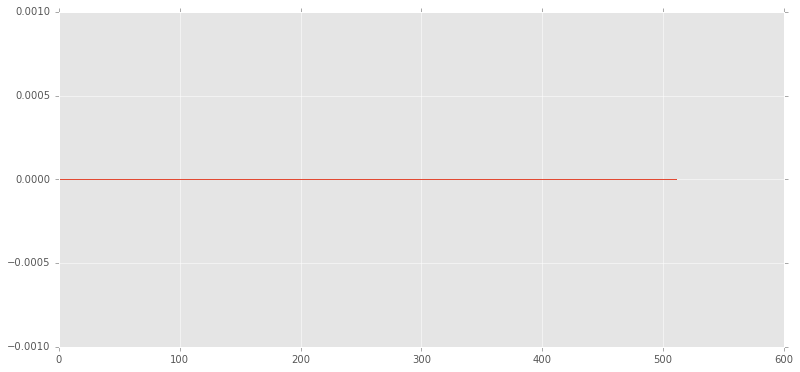

start 0, stop 0, avg 0


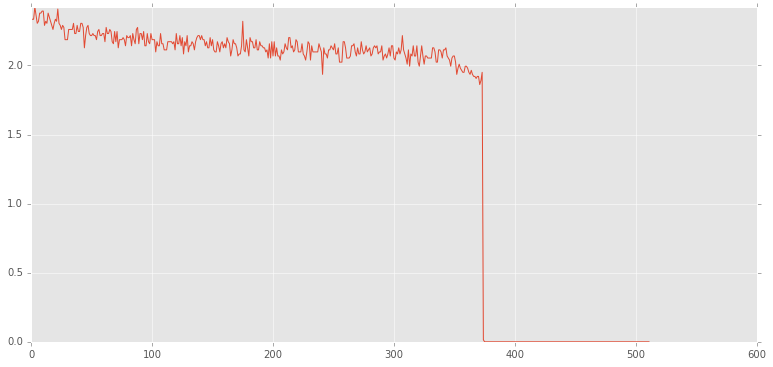

start 0, stop 374, avg 2.13683176041


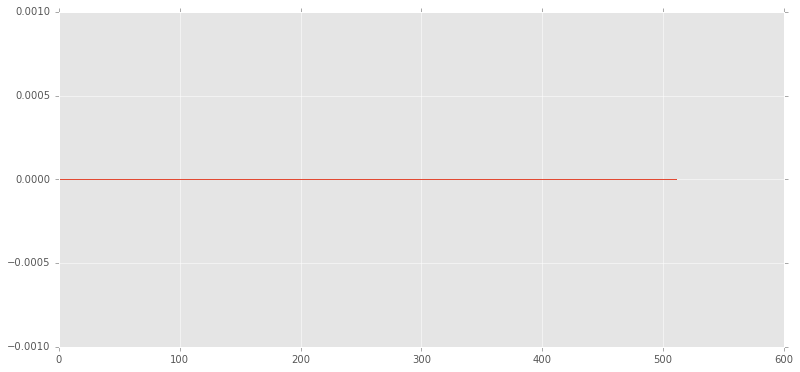

start 0, stop 0, avg 0


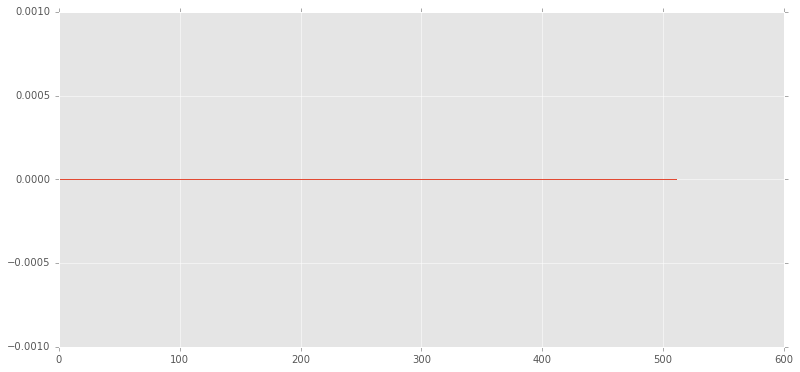

start 0, stop 0, avg 0


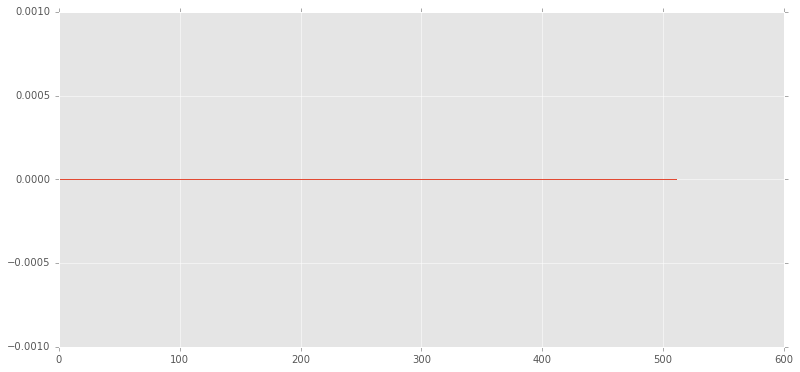

start 0, stop 0, avg 0


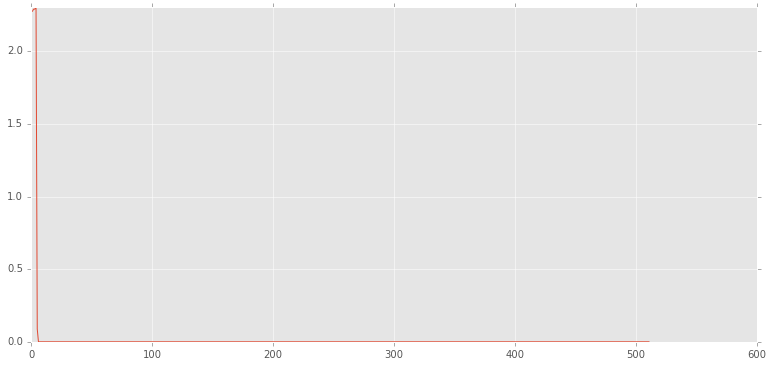

start 0, stop 5, avg 1.92079639435


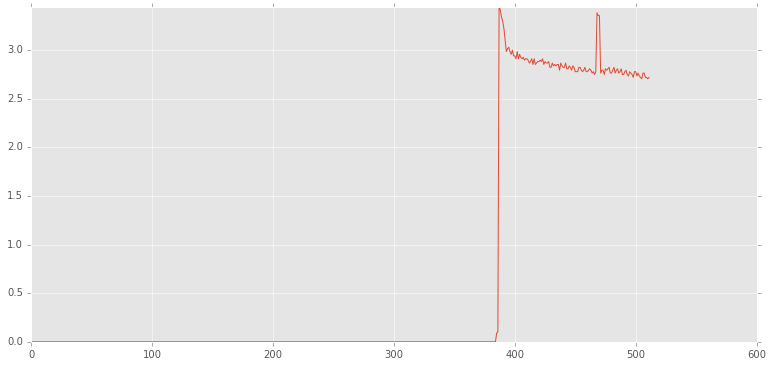

start 385, stop 511, avg 2.8188354969


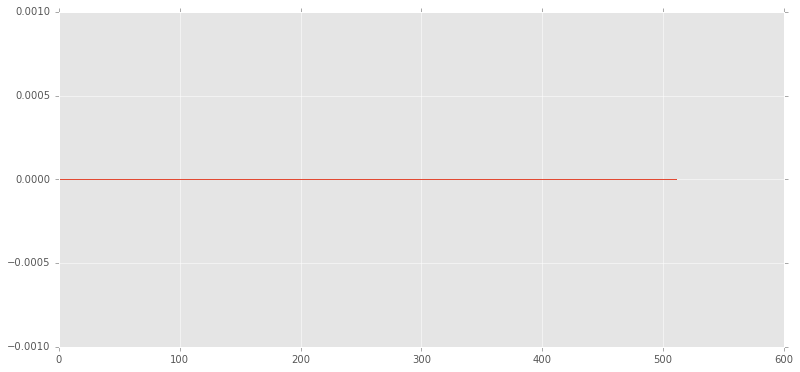

start 0, stop 0, avg 0


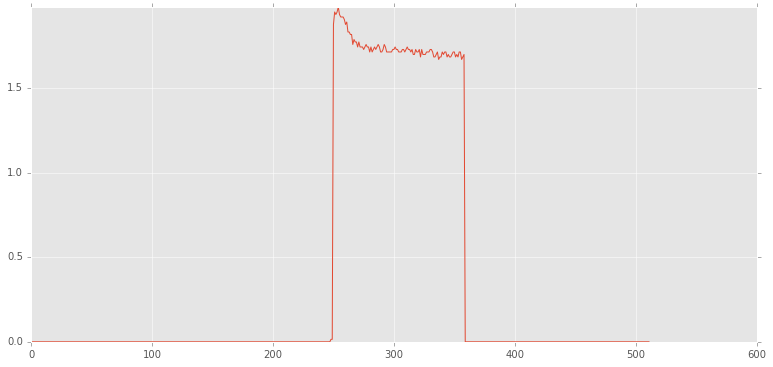

start 248, stop 358, avg 1.71474027634


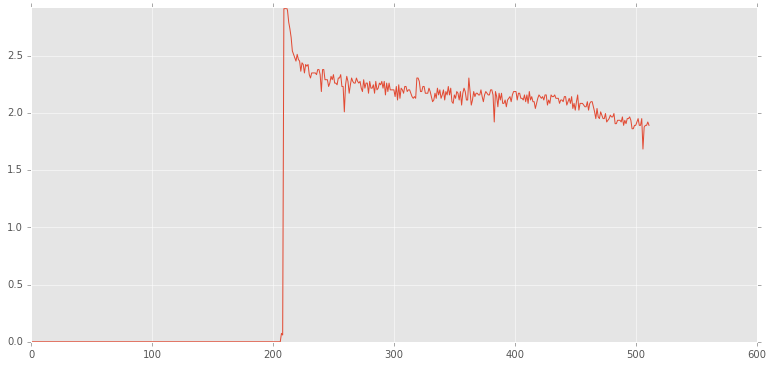

start 207, stop 511, avg 2.15458607674


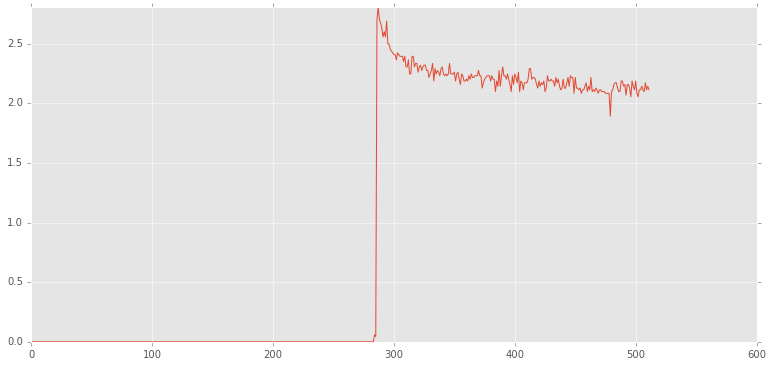

start 284, stop 511, avg 2.20379638672


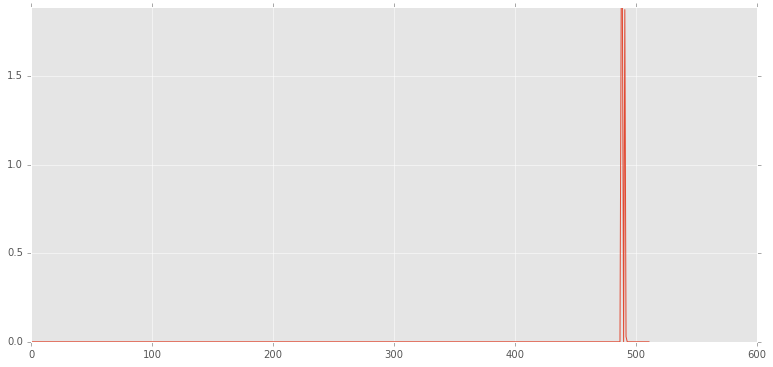

start 488, stop 492, avg 1.13770246506


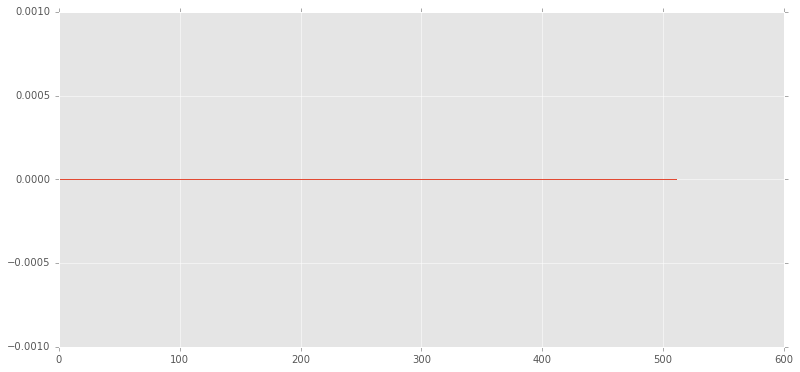

start 0, stop 0, avg 0


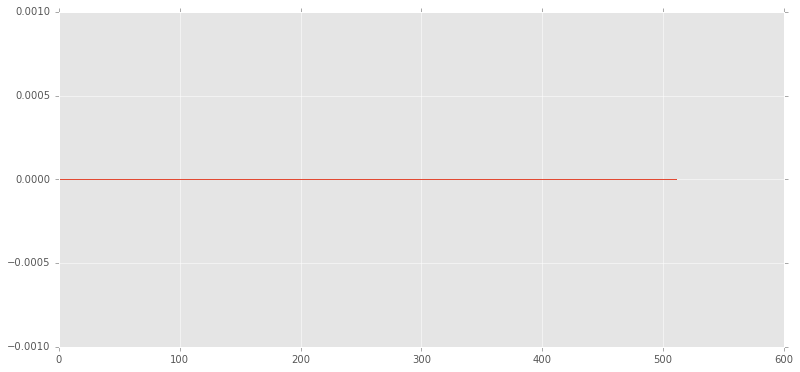

start 0, stop 0, avg 0


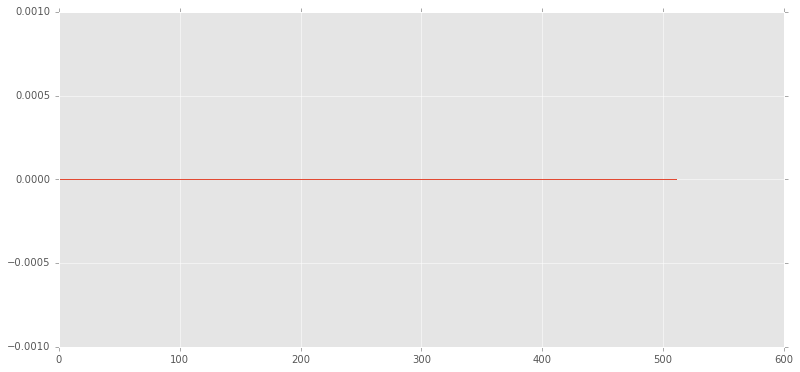

start 0, stop 0, avg 0


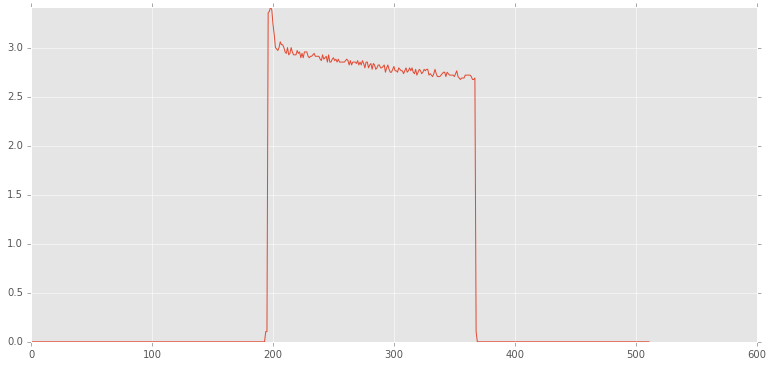

start 194, stop 368, avg 2.7920358181


In [126]:
new_batch = pipeline.get_batch(fold = ' train', source_id = 0)
for b in range(30):
    get_plot(new_batch, b, 1)




In [138]:
def get_start_stop_avg_power(new_batch):
    
    batch_size = new_batch.target.shape[0]
    start_nparray = np.empty(batch_size)
    stop_nparray = np.empty(batch_size)
    avgpower_nparray = np.empty(batch_size)
    neural_net_output = np.empty((batch_size, 3))
    
    for b in range(batch_size):
        seq =  new_batch.target[b]

        # case 1 and 2: if the signal start at 0
        if seq[0] > 0:
            start = 0
            stop_array = np.where(seq > 0)[0]
            # case 2: signal stops after 1
            # set stop to the last element
            if len(stop_array) == 0:
                stop = seq[-1]
            # case 1: signal stops before 1
            else:
                stop = stop_array[-1]  
            # calculate avg power
            avg_power =  np.mean(seq[start:stop + 1])

        # case 3: signal starts after 0 and before 1
        else:
            start_array = np.where(seq > 0)[0]
            if len(start_array) == 0:
                # case 5: there is no signal in the window
                start = 0
                stop = 0
                avg_power = 0
            else:
                start = start_array[0]
                # find stop
                stop_array = np.where(seq > 0)[0]
                # case 4: signal stops after 1
                # set to the last element
                if len(stop_array) == 0:
                    stop = seq[-1]
                else:
                    stop = stop_array[-1]        
                avg_power =  np.mean(seq[start:stop + 1])
                
        start_nparray[b] = start
        stop_nparray[b] = stop
        avgpower_nparray[b] = avg_power
        if stop < start:
        raise ValueError(
            "start must be before stop in sequence {}"
            .format(b))        
        neural_net_output[b, :] = np.array([start, stop, avg_power])


    
    return neural_net_output
        

In [139]:
get_start_stop_avg_power(new_batch)

(array([   0.,    0.,    0.,    0.,   67.,    0.,    0.,    0.,  268.,
           0.,    0.,    0.,    0.,    0.,    0.,    0.,    0.,    0.,
           0.,    0.,  385.,    0.,  248.,  207.,  284.,  488.,    0.,
           0.,    0.,  194.,    0.,  388.,    0.,  196.,  332.,  410.,
           0.,  238.,    0.,    0.,    0.,    0.,    0.,  357.,  327.,
           0.,    0.,    0.,   99.,  284.,    0.,    0.,  213.,    0.,
         477.,    0.,    0.,    0.,    0.,  337.,    0.,    0.,  197.,    0.]),
 array([   0.,    0.,    0.,    0.,  269.,    0.,    0.,    0.,  480.,
           0.,    0.,    0.,   80.,    0.,    0.,  374.,    0.,    0.,
           0.,    5.,  511.,    0.,  358.,  511.,  511.,  492.,    0.,
           0.,    0.,  368.,    0.,  511.,    0.,  357.,  511.,  511.,
           0.,  379.,    0.,  187.,   45.,    0.,    0.,  490.,  511.,
           0.,   24.,    0.,  220.,  511.,    0.,    0.,  415.,    0.,
         511.,    0.,   18.,  147.,    0.,  511.,    0.,    0.,  342

In [140]:
sample = real_agg_source.get_batch(num_seq_per_batch=1024).next()
sample = sample.before_processing
input_std = sample.input.flatten().std()
target_std = sample.target.flatten().std()
pipeline = DataPipeline(
    [synthetic_agg_source, real_agg_source],
    num_seq_per_batch=num_seq_per_batch,
    input_processing=[DivideBy(input_std), IndependentlyCenter()],
    target_processing=[DivideBy(target_std)]
)


In [24]:
new_batch = pipeline.get_batch(fold = 'train', source_id = 0)
batch = pipeline.flow(fold = 'train', source_id = 0)

# Training using Keras

## Using fit_generator

In [16]:
# get the shape of X_train
(X_train, Y_train) = pipeline.train_generator().next()
print(X_train.shape)

(64, 1, 512)


In [21]:
from keras.models import Sequential
from keras.layers import Dense, Dropout, Activation, Flatten
from keras.layers import Convolution1D,MaxPooling1D
from keras.optimizers import SGD
import time
starting_time = time.time()
nb_epoch = 1
# define the network architecture = Conv Net
model = Sequential()
model.add(Convolution1D(64, 3, border_mode='same',
                        input_shape = (1, X_train.shape[2]), 
                        init = 'normal', activation =  'relu'))
model.add(Flatten())
model.add(Dense(32))
model.add(Activation('relu'))
model.add(Dense(3, activation='sigmoid'))
# compile the model
sgd = SGD(lr=0.1, decay=1e-6, momentum=0.9, nesterov=True)
model.compile(loss='mean_squared_error',
              optimizer=sgd)
compiling_time = time.time() - starting_time
print('compiling time = ', compiling_time)
model.fit_generator(pipeline.train_generator(fold = ' train', source_id = 0), \
                    samples_per_epoch = 64064, \
                    nb_epoch = 2)

compiling time =  0.0266909599304
Epoch 1/2
20480/64064 [========>.....................]

ValueError: I/O operation on closed file

## with fit method (get rid off the generator for testing purposes)

In [195]:
num_batch = 1000
(X_train, Y_train) = pipeline.train_generator(fold = ' train', source_id = 0).next()
for _ in range(num_batch):
    (x,y) = pipeline.train_generator(fold = ' train', source_id = 0).next()
    X_train = np.vstack((X_train,x))
    Y_train = np.vstack((Y_train,y))

In [215]:
Y_train.astype(np.float32)

array([[ 0.        ,  0.15264188,  2.59322596],
       [ 0.14090019,  0.15459883,  0.45116591],
       [ 0.        ,  0.07436399,  2.56799293],
       ..., 
       [ 0.        ,  0.        ,  0.        ],
       [ 0.        ,  0.        ,  0.        ],
       [ 0.74363995,  1.        ,  2.69881392]], dtype=float32)

In [197]:
X_train.shape

(64064, 512, 1)

In [ ]:
X_train = np.reshape(X_train, [64064,1, 512, 1])

In [229]:
from keras.models import Sequential
from keras.layers import Dense, Dropout, Activation, Flatten
from keras.layers import Convolution2D
from keras.optimizers import SGD
import time
starting_time = time.time()
nb_epoch = 1
# define the network architecture = Conv Net
model = Sequential()
# # first layer
model.add(Convolution2D(64, 3, 1, border_mode='same',
                        input_shape = (X_train.shape[1], X_train.shape[2], 1), 
                        init = 'normal', activation =  'relu'))
model.add(Flatten())
model.add(Dense(32))
model.add(Activation('relu'))
model.add(Dense(3, activation='sigmoid'))
# compile the model
sgd = SGD(lr=0.1, decay=1e-6, momentum=0.9, nesterov=True)
model.compile(loss='mean_squared_error',
              optimizer=sgd)
compiling_time = time.time() - starting_time
print('compiling time = ', compiling_time)
model.fit(X_train, Y_train, batch_size=num_seq_per_batch, nb_epoch=2)

compiling time =  0.04114818573
Epoch 1/2
64064/64064 [==============================] - 52s - loss: 0.8001    
Epoch 2/2
64064/64064 [==============================] - 118s - loss: 0.7995   


In [230]:
X_train = np.reshape(X_train, [64064,1,512])

In [231]:
from keras.models import Sequential
from keras.layers import Dense, Dropout, Activation, Flatten
from keras.layers import Convolution1D
from keras.optimizers import SGD
import time
starting_time = time.time()
nb_epoch = 1
# define the network architecture = Conv Net
model = Sequential()
# # first layer
model.add(Convolution1D(64, 3, border_mode='same',
                        input_shape = (1, X_train.shape[2]), 
                        init = 'normal', activation =  'relu'))
model.add(Flatten())
model.add(Dense(32))
model.add(Activation('relu'))
model.add(Dense(3, activation='sigmoid'))
# compile the model
sgd = SGD(lr=0.1, decay=1e-6, momentum=0.9, nesterov=True)
model.compile(loss='mean_squared_error',
              optimizer=sgd)
compiling_time = time.time() - starting_time
print('compiling time = ', compiling_time)
model.fit(X_train, Y_train, batch_size=num_seq_per_batch, nb_epoch=2)

compiling time =  0.0262930393219
Epoch 1/2
64064/64064 [==============================] - 11s - loss: 0.5312    
Epoch 2/2
64064/64064 [==============================] - 11s - loss: 0.5149    
